In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pylab as plt
import matplotlib.pyplot as pyplt
from matplotlib import gridspec

import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2

import cmath
import random

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm
import scipy as sp
import scipy.fftpack

import lib
import library

# Генерация данных

In [2]:
dataset = library.creat_dataset()
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 13)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0,0.0,102.0,188.0,46.0,1.0,1.0


/home/apxapa/Документы/GitHub/2020_Project8/code/library.py:144: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('../data/data.png')
/home/apxapa/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


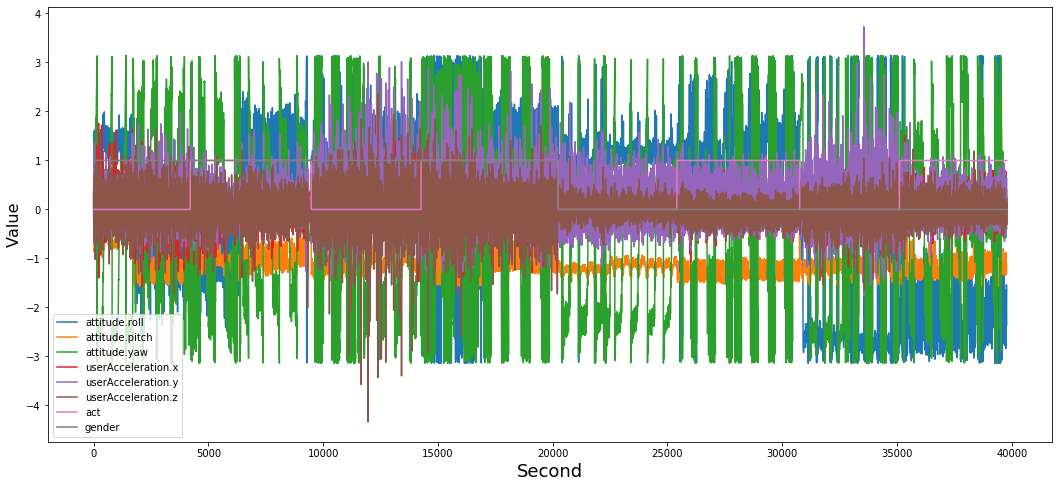

In [3]:
data = dataset.loc[(dataset['id'] < 3)|(dataset['id'] == 4)].loc[(dataset['trial'] > 0)&(dataset['trial'] < 5)]

data = data[['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z','act', 'gender']]
data.index = np.arange(len(data))

T = 50
K = 2
discrete = T//5
size_data = 39150

X_data = data.values[:size_data, :6]
List_of_x = np.arange(2*T, X_data.shape[0] - T) #ось времени

library.drow_data_multi(data)

# Извлечение признаков

Сингулярные числа (по 4 на ряд) разложения фазовой траектории:

In [6]:
N_comp = 10

def get_spectrum_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'specrum_' + str(i)]
    return feature_names

feature_names = get_spectrum_names(N_comp)

# phase track для каждой точки от T до len(phase_track) - (N, len, T)
phase_track = lib.return_phase_track(X_data, T) 

# basis vector - 2 компоненты сингулярного разложения в точках 2T,2T+discrete.. max-T-discrete - (len, 2*N)
List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c = lib.local_basis_multi(phase_track, T = T, 
                                                                      N_components = N_comp, discrete = discrete)

specrum_feats = pd.DataFrame(List_of_basis_vector_s,columns = feature_names)

specrum_feats

,roll_specrum_0,roll_specrum_1,roll_specrum_2,roll_specrum_3,roll_specrum_4,roll_specrum_5,roll_specrum_6,roll_specrum_7,roll_specrum_8,roll_specrum_9,...,z_acc_specrum_0,z_acc_specrum_1,z_acc_specrum_2,z_acc_specrum_3,z_acc_specrum_4,z_acc_specrum_5,z_acc_specrum_6,z_acc_specrum_7,z_acc_specrum_8,z_acc_specrum_9
0,7.536991,7.183248,3.028250,2.980463,1.245050,1.083378,0.959384,0.531102,0.497449,0.427274,...,7.354067,6.791222,5.701408,5.634969,4.640838,4.571312,3.362675,3.302001,2.350317,2.245514
1,11.400271,11.089366,5.095827,3.910886,3.847797,2.281377,1.450809,1.363604,1.081720,0.687761,...,9.890864,9.717974,7.960496,7.661147,7.301171,5.572072,5.564885,5.330676,4.699782,4.407129
2,11.584641,10.320471,6.429126,3.879523,3.858760,1.907859,1.465496,1.340111,0.938938,0.688081,...,10.227312,10.002029,7.791031,7.680268,7.164099,5.517456,5.284406,5.207967,4.626768,4.449363
3,11.126887,10.195186,6.768973,4.285491,3.890349,2.060183,1.409191,1.226774,0.822758,0.655821,...,10.168470,9.935055,7.485211,7.392953,6.519357,5.334691,5.234666,4.645132,4.566336,4.419341
4,10.605056,10.226431,6.286216,4.894995,4.248490,2.172869,1.258247,1.075230,0.717904,0.597276,...,10.197042,9.749375,7.373946,7.043747,5.924277,5.282616,5.204226,5.024350,4.624654,4.320321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,21.215894,19.363435,3.411772,3.161109,1.752104,1.611185,0.898093,0.753571,0.748237,0.650525,...,4.190980,4.042245,2.740010,2.719301,2.535955,2.398770,2.024341,1.778767,1.725957,1.582623
3896,22.199313,18.381109,3.363006,3.032202,1.873260,1.624140,0.909016,0.741238,0.725013,0.585252,...,4.385237,3.991238,2.901972,2.788671,2.718269,2.421509,1.888063,1.841006,1.722693,1.549410
3897,23.464441,17.458905,3.204594,2.874497,1.963796,1.884246,0.956806,0.710328,0.641037,0.634221,...,4.473092,4.097695,2.932171,2.813403,2.684377,2.340848,2.036693,1.852390,1.748293,1.612817
3898,21.469315,19.949396,3.110702,2.602064,1.987169,1.908184,1.018382,0.780384,0.724633,0.594823,...,4.591283,4.197066,2.815965,2.654471,2.641486,2.490725,2.007986,1.859407,1.737104,1.578774


Параметры авторегрессии (по 50 на ряд):

In [7]:
n = 10   # with free coef

def get_autoregressive_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'autoreg_' + str(i)]
    return feature_names

feature_names = get_autoregressive_names(n)

def get_autoreg_feat_segm(ts, n):
    m = ts.shape[1]
    features = []
    for row in ts:
        X = np.zeros([m-n, n])
        Y = np.zeros(m-n)
        for i in range(m-n):
            X[i, :] = row[i:i+n]
            Y[i] = row[i+n]
        lr = LinearRegression()
        lr.fit(X, Y)
        features.append(lr.intercept_)
        features.extend(lr.coef_)  
    return features

def get_autoreg_features(X_data, n, discrete):
    if(n == 0): return np.asarray([])
    size = (X_data.shape[0]-3*T)//discrete
    params_autoreg = [None]*size
    for i in range(size):
        segm = lib.return_h(X_data, 2*T+i*discrete, 2*T)       
        params_autoreg[i] = get_autoreg_feat_segm(segm, n)   #n*N_row features
    return(np.asarray(params_autoreg))
    
params_autoreg = get_autoreg_features(X_data, n-1, discrete)
autoreg_feats = pd.DataFrame(params_autoreg,columns = feature_names)
autoreg_feats.to_csv("../data/features/autoreg_feats.csv", index=False)
autoreg_feats

,roll_autoreg_0,roll_autoreg_1,roll_autoreg_2,roll_autoreg_3,roll_autoreg_4,roll_autoreg_5,roll_autoreg_6,roll_autoreg_7,roll_autoreg_8,roll_autoreg_9,...,z_acc_autoreg_0,z_acc_autoreg_1,z_acc_autoreg_2,z_acc_autoreg_3,z_acc_autoreg_4,z_acc_autoreg_5,z_acc_autoreg_6,z_acc_autoreg_7,z_acc_autoreg_8,z_acc_autoreg_9
0,0.048403,-0.221375,0.628660,-0.692835,0.452146,-0.530606,0.652044,-0.102484,-1.292210,2.071169,...,0.017033,-0.022880,-0.047565,-0.058180,0.091636,-0.214621,0.068116,-0.119237,-0.134778,0.867817
1,0.055398,-0.102114,0.296853,-0.239114,-0.064468,0.019652,0.147421,0.224069,-1.370013,2.047654,...,0.025526,-0.006995,-0.041273,-0.086408,0.108704,-0.223458,0.096263,-0.138632,-0.141410,0.900741
2,0.037877,-0.119368,0.308428,-0.251400,-0.041358,0.010723,0.158048,0.184682,-1.322224,2.043887,...,0.040530,0.044128,-0.007050,-0.059433,0.099395,-0.194975,0.137113,-0.157688,-0.131540,0.938699
3,0.026414,-0.186278,0.393681,-0.176692,-0.095405,0.022112,0.080810,0.064957,-1.095015,1.971009,...,0.038209,0.007731,-0.000546,-0.038702,0.077875,-0.207616,0.147189,-0.165595,-0.085173,0.930713
4,0.031167,-0.142322,0.321256,-0.182905,-0.067477,0.028922,0.076434,0.110243,-1.136933,1.967411,...,0.063321,0.035891,-0.049868,-0.118530,0.142434,-0.204745,0.140985,-0.111452,-0.171034,0.943674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,-0.050025,-0.038469,-0.092350,0.151113,-0.079953,0.063542,0.308465,-0.495407,-0.770914,1.931396,...,-0.012436,-0.011895,-0.048474,-0.055949,-0.030469,0.130412,-0.161783,0.374027,-0.228884,0.653801
3896,-0.052290,-0.047350,-0.087008,0.177406,-0.072143,0.005536,0.307535,-0.442143,-0.798111,1.932239,...,-0.015275,-0.015407,-0.102023,-0.004464,-0.050666,0.120252,-0.145363,0.395873,-0.219097,0.619544
3897,-0.050101,-0.035161,-0.108348,0.184185,-0.057128,-0.008822,0.299121,-0.427532,-0.790584,1.921767,...,-0.015377,-0.009505,-0.088002,-0.024740,-0.081744,0.096556,-0.190468,0.409242,-0.218474,0.699000
3898,-0.039723,-0.036978,-0.160669,0.418499,-0.268006,-0.165196,0.647694,-0.559507,-0.902651,2.009179,...,-0.026665,0.007112,-0.108780,-0.033136,-0.074235,0.088167,-0.211978,0.426366,-0.245465,0.666002


Коэффициенты Фурье разложения:

In [8]:
def get_fft_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'fft_' + str(i)]
    return feature_names

feature_names = get_fft_names(2*T)

def get_fft_features_segm(ts, n):
    m = ts.shape[1]
    features = []
    
    for row in ts:
        h = sp.fftpack.rfft(row, n, axis=-1, overwrite_x=False)
        features.extend(h)
    
    return list(np.array(features)**2)

def get_fft_features(X_data, n, discrete):
    if(n == 0): return np.asarray([])
    size = (X_data.shape[0]-3*T)//discrete
    params_fft = [None]*size
    for i in range(size):
        segm = lib.return_h(X_data, 2*T+i*discrete, n)  
        params_fft[i] = get_fft_features_segm(segm, n)   #n*N_row features
    return(np.asarray(params_fft))
  
params_fft = get_fft_features(X_data, n = 100, discrete = discrete)
fft_feats = pd.DataFrame(params_fft,columns = feature_names)
fft_feats.to_csv("../data/features/fft_feats.csv", index=False)
fft_feats

,roll_fft_0,roll_fft_1,roll_fft_2,roll_fft_3,roll_fft_4,roll_fft_5,roll_fft_6,roll_fft_7,roll_fft_8,roll_fft_9,...,z_acc_fft_90,z_acc_fft_91,z_acc_fft_92,z_acc_fft_93,z_acc_fft_94,z_acc_fft_95,z_acc_fft_96,z_acc_fft_97,z_acc_fft_98,z_acc_fft_99
0,18866.268560,2.122149,3.310885,81.678866,106.273230,4.585390,10.798800,7.472270,1.361805,21.004341,...,0.008873,0.000073,2.461225,0.511450,0.770477,0.796658,0.375123,0.012852,1.622611,2.597686
1,18442.413797,0.512177,0.765175,71.927741,126.790125,1.238647,5.159756,7.235941,2.341931,13.497772,...,0.054697,0.846246,1.174710,1.112419,0.202969,0.624193,0.386527,0.264176,1.301424,3.190167
2,17782.518272,1.243224,1.638643,221.205709,40.116021,9.850671,3.015823,2.433564,23.004067,7.222349,...,0.092859,1.606543,0.145890,0.022180,1.018894,0.083184,1.202576,1.530649,0.271205,2.556875
3,17104.109388,6.890511,5.163327,0.615304,295.654784,0.637748,15.415112,0.035398,9.539325,3.143661,...,0.044460,2.522265,0.079543,0.354758,0.000142,2.646838,0.009556,0.555588,0.044256,4.778377
4,15957.184776,24.139712,24.024125,166.692915,77.261798,2.500752,2.048749,6.294702,34.154673,1.366637,...,0.013453,1.980691,0.656558,0.049196,0.832219,0.010036,1.689772,1.163919,0.584977,2.410989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,47870.192188,10.744497,31.503473,60.695109,741.748714,7.327387,39.528677,8.649952,8.531553,0.304207,...,0.005158,0.105741,0.878643,0.098516,0.013281,0.019784,0.182960,0.455795,0.000234,0.001314
3896,45886.903473,101.388701,0.568817,647.648853,18.211945,32.069821,20.357115,0.012663,0.217856,1.616986,...,0.241546,0.390085,0.005276,0.091280,0.002592,0.003199,0.065668,0.010527,0.079119,0.168615
3897,46563.064375,49.341668,25.951260,181.132213,544.099807,16.056395,55.724081,1.326933,0.238449,0.019626,...,0.254093,0.034814,0.079687,0.214779,0.101863,0.294385,0.005386,0.028637,0.066727,0.028921
3898,49943.606735,20.586798,35.592641,146.437509,583.507126,18.071404,46.035955,0.797093,34.119014,0.282655,...,0.272417,0.020069,0.310227,0.019791,0.040221,0.000020,0.025606,0.175444,0.010809,0.408361


In [62]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import GroupKFold

def selecting(X_feat,y, model, n_feat = 20):
    mask1 = [True if i % 600 < 400 else False for i in range(3900)]
    mask2 = [True if i % 600 > 399 else False for i in range(3900)]
    #X_train, y_train = X_feat[mask1], y[mask1]
    X_test, y_test = X_feat[mask2], y[mask2]
    X_train, y_train = X_feat, y

    X_train = sklearn.preprocessing.MinMaxScaler().fit_transform(X_train)
    X_test = sklearn.preprocessing.MinMaxScaler().fit_transform(X_test)

    select_feat = SelectPercentile(chi2, percentile=5)
    X_train = select_feat.fit_transform(X_train, y_train)

    best_feat = select_feat.get_support()
    bestmask = select_feat.get_support(indices=False)
    best = [[x,z] for x,y,z in zip(X_feat.columns, select_feat.get_support(), select_feat.scores_) if y == 1]
    best = pd.DataFrame(best) 
    
    X_test = select_feat.transform(X_test)
    plt.rcParams['figure.figsize'] = (18.0, 8.0)
    plt.bar([ str(i) for i in best[0]], best[1], color='g')
    
    groups = np.arange(len(y_train)) // 300
    cv_gen = GroupKFold(13).split(X_train, y_train, groups)
    cv = list(cv_gen)

    sfs = SFS(model, k_features=n_feat, forward=False, floating=True, scoring='accuracy', 
          cv=cv, n_jobs=-1, verbose = 2)

    sfs.fit(X_train, y_train)
    print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))

    X_train_sfs = sfs.transform(X_train)
    X_test_sfs = sfs.transform(X_test)
    
    best2 = np.asarray(best[0])
    mask = [i in sfs.k_feature_idx_ for i,x in enumerate(best[0])]
    best2 = best2[mask]
    
    df_train = pd.DataFrame(data=X_train_sfs, columns=best2)
    df_train.insert(2, "y", y_train, True)
    df_test = pd.DataFrame(data=X_test_sfs, columns=best2)
    df_test.insert(2, "y", y_test, True)
    
    return df_train, df_test

In [63]:
import warnings
warnings.filterwarnings('ignore')
14

In [80]:
def Experiment(MODEL = LogisticRegression):
    result = np.zeros(9)
    
    # features Деятельность:
    X_feat = pd.concat([fft_feats, autoreg_feats, specrum_feats], axis=1)
    y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 6]) if i % discrete == 0])

    df_train_act, df_test_act = selecting(X_feat,y, MODEL(), 14)
    df_train_act.to_csv("../data/df_train_act.csv", index=False)

    X_train_act, y_train_act = df_train_act.drop(['y'], axis=1), df_train_act[['y']]
    best_act = X_train_act.columns  
    
    # features Пол:
    X_feat = pd.concat([fft_feats, autoreg_feats, specrum_feats], axis=1)
    y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 7]) if i % discrete == 0])

    df_train_gen, df_test_gen = selecting(X_feat,y, MODEL(), 8)
    df_train_gen.to_csv("../data/df_train_gen.csv", index=False)

    X_train_gen, y_train_gen = df_train_gen.drop(['y'], axis=1), df_train_gen[['y']]
    best_gen = X_train_gen.columns
    
    # Действия
    groups = np.arange(len(y_train_act)) // 300
    cv_act = GroupKFold(13).split(X_train_act, y_train_act, groups)
    cv = list(cv_act)

    clf = MODEL()
    scores = cross_val_score(clf, X_train_act, y_train_act, cv=cv)
    print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    result[0], result[1]=scores.mean(), scores.std() * 2

    # Пол
    groups = np.arange(len(y_train_gen)) // 300
    cv_gen = GroupKFold(13).split(X_train_gen, y_train_gen, groups)
    cv = list(cv_gen)

    clf = MODEL()
    scores = cross_val_score(clf, X_train_gen, y_train_gen, cv=cv)
    print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    result[2], result[3]=scores.mean(), scores.std() * 2
    
    # Активность на признаках + гендер
    clf = MODEL().fit(X_train_gen, y_train_gen)
    y_pred_gen = clf.predict(X_train_gen)
    X_train_act_g = X_train_act.assign(e=y_pred_gen)

    groups = np.arange(len(y_train_act)) // 300
    cv_gen = GroupKFold(13).split(X_train_act_g, y_train_act, groups)
    cv = list(cv_gen)

    clf = MODEL()
    scores = cross_val_score(clf, X_train_act_g, y_train_act, cv=cv)
    print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    result[4], result[5]=scores.mean(), scores.std() * 2

    # Гендер на признаках + активность
    clf = MODEL().fit(X_train_act, y_train_act)
    y_pred_act = clf.predict(X_train_act)
    X_train_gen_a = X_train_gen.assign(e=y_pred_act)

    groups = np.arange(len(y_train_gen)) // 300
    cv_gen = GroupKFold(13).split(X_train_gen_a, y_train_gen, groups)
    cv = list(cv_gen)

    clf = MODEL()
    scores = cross_val_score(clf, X_train_gen_a, y_train_gen, cv=cv)
    print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    result[6], result[7]=scores.mean(), scores.std() * 2
    
    result[8] = len(set(best_act) & set(best_gen))
     
    return result, X_train_act, y_train_act, X_train_gen, y_train_gen

In [ ]:
14 8

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   15.7s finished

[2020-04-19 02:36:27] Features: 35/14 -- score: 0.8917948717948718[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished

[2020-04-19 02:36:40] Features: 34/14 -- score: 0.8941025641025641[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s finished

[2020-04-19 02:36:53] Features: 33/14 -- score: 0.8994871794871796[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurre

[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.1s finished

[2020-04-19 02:40:13] Features: 17/14 -- score: 0.9069230769230768[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.9s finished

[2020-04-19 02:40:20] Features: 16/14 -- score: 0.9066666666666668[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 conc

best combination (ACC: 0.908): (6, 7, 8, 9, 11, 12, 13, 14, 17, 23, 25, 26, 33, 35)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   10.5s finished

[2020-04-19 02:40:56] Features: 35/8 -- score: 0.9366666666666666[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished

[2020-04-19 02:41:07] Features: 34/8 -- score: 0.9389743589743589[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s finished

[2020-04-19 02:41:17] Features: 33/8 -- score: 0.9412820512820514[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent 

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.4s finished

[2020-04-19 02:43:56] Features: 15/8 -- score: 0.9523076923076922[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    3.7s finished

[2020-04-19 02:44:02] Features: 14/8 -- score: 0.9530769230769229[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    3.8s finished

[2020-04-19 02:44:09] Features: 13/8 -- score: 0.9535897435897435[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    2.1s remai

best combination (ACC: 0.952): (0, 1, 2, 4, 5, 13, 17, 34)

Accuracy cross validation: 0.908 (+/- 0.147)
Accuracy cross validation: 0.952 (+/- 0.152)
Accuracy cross validation: 0.903 (+/- 0.152)
Accuracy cross validation: 0.950 (+/- 0.136)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.0min finished

[2020-04-19 02:45:45] Features: 35/14 -- score: 0.9148717948717949[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   59.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished

[2020-04-19 02:46:49] Features: 34/14 -- score: 0.9184615384615384[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   57.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.7s finished

[2020-04-19 02:47:53] Features: 33/14 -- score: 0.9207692307692308[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurre

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.6s finished

[2020-04-19 03:03:40] Features: 15/14 -- score: 0.9323076923076924[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   24.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.3s finished

[2020-04-19 03:04:42] Features: 15/14 -- score: 0.9338461538461538[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   24.1s finished

[2020-04-19 03:05:24] Features: 14/14 -- score: 0.933589743

best combination (ACC: 0.934): (0, 8, 9, 10, 11, 12, 14, 20, 22, 23, 28, 33, 34, 35)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   32.4s finished

[2020-04-19 03:05:59] Features: 35/8 -- score: 0.9615384615384616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   32.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished

[2020-04-19 03:06:34] Features: 34/8 -- score: 0.9630769230769229[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   31.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s finished

[2020-04-19 03:07:08] Features: 33/8 -- score: 0.9638461538461538[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent 

[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   10.7s finished

[2020-04-19 03:16:15] Features: 16/8 -- score: 0.9715384615384614[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.8s finished

[2020-04-19 03:16:36] Features: 15/8 -- score: 0.9728205128205129[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   11.5s finished

[2020-04-19 03:16:56] Features: 14/8 -- score: 0.972307692307

best combination (ACC: 0.971): (0, 2, 4, 5, 17, 20, 24, 35)

Accuracy cross validation: 0.934 (+/- 0.097)
Accuracy cross validation: 0.971 (+/- 0.074)
Accuracy cross validation: 0.933 (+/- 0.101)
Accuracy cross validation: 0.966 (+/- 0.072)


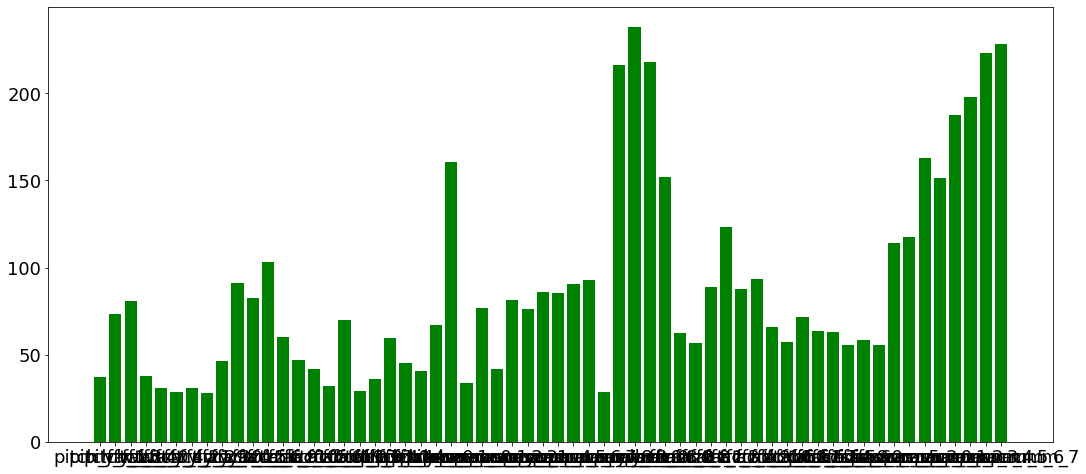

In [81]:
result = np.zeros((2,9))
result[0], X_train_act1, y_train_act1, X_train_gen1, y_train_gen1 = Experiment(LogisticRegression)
result[1], X_train_act2, y_train_act2, X_train_gen2, y_train_gen2 = Experiment(svm.SVC)

In [82]:
columns = ["act", "d act","gender","d gender", "act(+g)","d act(+g)","gen(+a)","d gen(+a)", "common",]
rows = ["LogRegression", "SVM"]
res = pd.DataFrame(data=result, index=rows, columns=columns)
res = np.round(res, 3)
res.to_csv("../data/result.csv", index=False)
res

,act,d act,gender,d gender,act(+g),d act(+g),gen(+a),d gen(+a),common
LogRegression,0.908,0.147,0.952,0.152,0.903,0.152,0.950,0.136,1.0
SVM,0.934,0.097,0.971,0.074,0.933,0.101,0.966,0.072,1.0


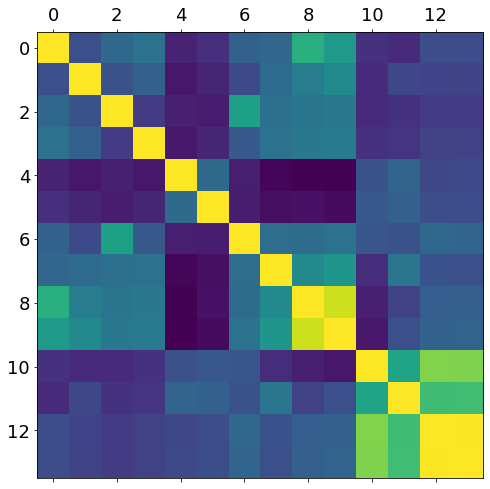

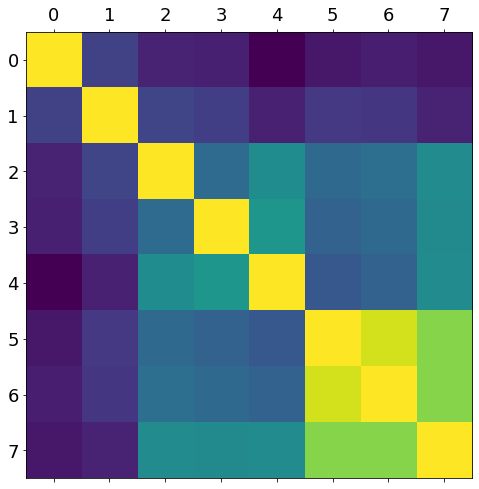

In [191]:
import matplotlib.pyplot as plt

plt.matshow(X_train_act2.corr())
plt.show()

plt.matshow(X_train_gen2.corr())
plt.show()

In [195]:
X_train_gen2.columns

Index(['roll_fft_0', 'y_acc_fft_8', 'z_acc_fft_3', 'z_acc_fft_4',
       'pitch_specrum_3', 'x_acc_specrum_4', 'x_acc_specrum_8',
       'z_acc_specrum_9'],
      dtype='object')

In [196]:
X_train_act2.columns

Index(['pitch_fft_1', 'y_acc_fft_4', 'y_acc_fft_5', 'y_acc_fft_6',
       'y_acc_fft_9', 'y_acc_fft_10', 'z_acc_fft_6', 'roll_specrum_0',
       'pitch_specrum_0', 'pitch_specrum_1', 'x_acc_specrum_5',
       'y_acc_specrum_9', 'z_acc_specrum_8', 'z_acc_specrum_9'],
      dtype='object')

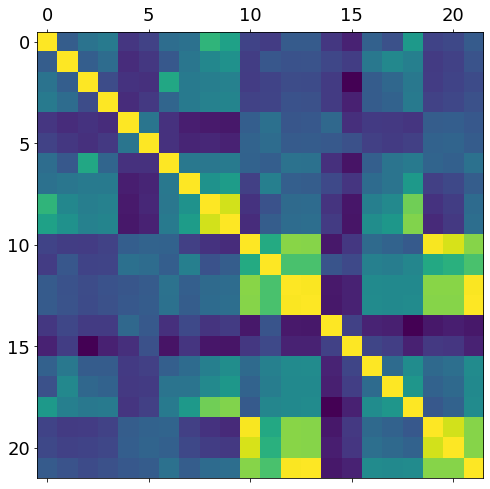

In [215]:
X_train_act = X_train_act2#[['pitch_fft_1', 'y_acc_fft_4', 'y_acc_fft_5', 'y_acc_fft_6',
       #'y_acc_fft_9', 'y_acc_fft_10', 'z_acc_fft_6', 'roll_specrum_0',
      # 'pitch_specrum_0', 'pitch_specrum_1', 'x_acc_specrum_5',
       #'y_acc_specrum_9', 'z_acc_specrum_8', 'z_acc_specrum_9']]
X_train_gen = X_train_gen2#[['roll_fft_0', 'y_acc_fft_8', 'z_acc_fft_3', 'z_acc_fft_4',
      # 'pitch_specrum_3', 'x_acc_specrum_4']]
X_union = pd.concat([X_train_act, X_train_gen], axis=1)
plt.matshow(X_union.corr())
plt.show()

In [216]:
groups = np.arange(len(y_train_act1)) // 300
cv_gen = GroupKFold(13).split(X_union, y_train_act2, groups)
cv = list(cv_gen)

clf = svm.SVC()
scores = cross_val_score(clf, X_union, y_train_act2, cv=cv)
print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

groups = np.arange(len(y_train_act1)) // 300
cv_gen = GroupKFold(13).split(X_union, y_train_gen2, groups)
cv = list(cv_gen)

clf = svm.SVC()
scores = cross_val_score(clf, X_union, y_train_gen2, cv=cv)
print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy cross validation: 0.930 (+/- 0.108)
Accuracy cross validation: 0.983 (+/- 0.035)


In [218]:
matr_param1 = np.zeros([39, 22])
sc1 = np.zeros(39)
mean = np.zeros([2, 22])
for (i, tr) in enumerate(cv):
    clf = LogisticRegression()
    clf = clf.fit(X_union.loc[tr[0]], y_train_act1.loc[tr[0]])
    sc1[i] = clf.score(X_union.loc[tr[1]], y_train_act1.loc[tr[1]])
    matr_param1[i] = clf.coef_
mean[0] = matr_param1.mean(axis = 0)
    
matr_param2 = np.zeros([39, 22])
sc2 = np.zeros(39)
for (i, tr) in enumerate(cv):
    clf = LogisticRegression()
    clf = clf.fit(X_union.loc[tr[0]], y_train_gen1.loc[tr[0]])
    sc2[i] = clf.score(X_union.loc[tr[1]], y_train_gen1.loc[tr[1]])
    matr_param2[i] = clf.coef_
mean[1] = matr_param2.mean(axis = 0)

In [219]:
pd.DataFrame(mean)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.129366,1.512051,0.610126,1.200317,-1.113275,-1.175611,1.501826,0.730898,-0.302753,2.843159,...,-0.338223,-0.610690,0.076242,-0.371468,0.851550,0.579308,0.856236,0.177881,-1.441658,-0.610690
1,-0.054006,0.527869,-0.459916,-0.163181,-0.580275,-0.624089,0.574206,-0.872394,0.303812,0.861945,...,1.733531,2.041637,-2.454788,-1.678596,1.044447,1.161554,1.239724,0.823245,0.183616,2.041637


In [228]:
p = np.zeros(22)
for i, v in enumerate(matr_param1.T):
    stat, p[i] = scipy.stats.mannwhitneyu(matr_param1.T[i], matr_param2.T[i], alternative = 'two-sided')
    print(p[i])
print(max(p), p.mean())
p

0.21983169490990262
0.3170006714280382
4.981423052094865e-07
2.3898935698389006e-06
0.3170006714280382
0.3170006714280382
0.3170006714280382
4.981423052094865e-07
4.512378252801637e-06
0.3170006714280382
0.3170006714280382
0.3170006714280382
4.981423052094865e-07
4.981423052094865e-07
4.169858101344007e-05
0.3170006714280382
0.39106266576643656
0.3170006714280382
0.34666462767005946
0.3170006714280382
2.3898935698389006e-06
4.981423052094865e-07
0.39106266576643656 0.1876190538220324


array([2.19831695e-01, 3.17000671e-01, 4.98142305e-07, 2.38989357e-06,
       3.17000671e-01, 3.17000671e-01, 3.17000671e-01, 4.98142305e-07,
       4.51237825e-06, 3.17000671e-01, 3.17000671e-01, 3.17000671e-01,
       4.98142305e-07, 4.98142305e-07, 4.16985810e-05, 3.17000671e-01,
       3.91062666e-01, 3.17000671e-01, 3.46664628e-01, 3.17000671e-01,
       2.38989357e-06, 4.98142305e-07])

In [209]:
from scipy.stats import shapiro
stat, p = shapiro(matr_param2)
stat, p

(0.6862996816635132, 2.860629052889378e-33)